In [65]:

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


class RBF_Add(nn.Module):
    def __init__(self, add_rbf_number, device = device):
        super(RBF_Add, self).__init__()

        self.add_rbf_number = add_rbf_number
        self.radial_layer_centers_list = []
        self.radial_sigma_list = []
        self.linear_layer_weights_list = []
        
        
        self.total_radial_layer_centers_list = []
        self.total_radial_sigma_list = []
        self.total_linear_layer_weights_list = []
        
        self.change_th = 3

    def rbf_gaussian(self, input_data):
        output = torch.exp(-1 * (torch.pow((input_data - self.radial_layer_centers), 2) / \
                                 (torch.pow(self.radial_sigma, 2))))

        return output  # size = (num_rbf, 1)

    def done_rbf_gaussian(self, input_data, number):
        output = torch.exp(-1 * (torch.pow(
            (input_data - self.done_radial_layer_centers[number - 1 - self.add_rbf_number:number - 1]), 2) / \
                                 (torch.pow(self.done_radial_sigma[number - 1 - self.add_rbf_number:number - 1], 2))))

        return output  # size = (num_rbf, 1)

    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.radial_layer_centers) / \
                  (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    '''
    def rbf_gaussian_derivative_centers2(self, input_data):
        output = (2 / (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data) + \
                ((-2* (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * \
                 self.rbf_gaussian_derivative_centers(input_data))

        return output  # size = (num_radial, 1)
    '''
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.radial_layer_centers), 2) / \
                  (torch.pow(self.radial_sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    '''
    def rbf_gaussian_derivative_sigma2(self, input_data):
        output = (4 * (input_data - self.radial_layer_centers) / (torch.pow(self.radial_sigma, 3))) * \
                    self.rbf_gaussian(input_data) + (-2*(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)) * \
                    self.rbf_gaussian_derivative_sigma(input_data)

        return output  # size = (num_radial, 1)
    '''
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def Loss(self, pred, target, pred_grad, true_grad):
        
        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2))

    def forward(self, input_data):
        rbf_output = self.rbf_gaussian(input_data)
        pred = torch.mm(self.linear_layer_weights, rbf_output)

        return rbf_output, pred

    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_radial_layer_centers), 2) / \
                                     (torch.pow(self.done_radial_sigma, 2))))
        pred = torch.mm(self.done_linear_layer_weights, rbf_output)

        return rbf_output, pred
    
    def L2_F(self, input_data):
        return -2 * (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)
    

    def first_rbf_parameter(self, input_data, target):
        
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()
        find_sigma = target.clone().detach()
        
        target_std = target.std()
        
        find_weight = target.clone().detach()
        center_index_list = []

        for i in range(self.add_rbf_number):
            index_ = torch.argmax(torch.abs(fine_index_target)).cpu().detach().tolist()
            fine_index_target[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)
                            

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))
    
        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def init_rbf_parameter(self, input_data, error):
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        target_std = error.std()
        center_index_list = []

        for i in range(self.add_rbf_number * (self.change_time + 1)):
            index_ = torch.argmax(torch.abs(find_index_error)).cpu().detach().tolist()

            find_index_error[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft =  (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))

        initsigma = torch.cat(sigma_list)
        print(initcenter, initweight, initsigma)
        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1

    def best_forward(self, input_data, best_center, best_sigma, best_weight):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                     (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return rbf_output, pred    
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * radial_output

    def backward_propagation(self, input_data, radial_output, pred, target, target_grad, pred_grad):
        
        L2_1_error = -2 * (target - pred)

        L2_2_error = -2 * (target_grad - pred_grad)


        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error
        deltaSigma1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)

        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error
        deltaSigma2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)

        deltaSigma =  torch.sum(deltaSigma1, dim=1) + torch.sum(deltaSigma2, dim=1)

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error
        deltaCenter1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)

        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error
        deltaCenter2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaCenter =  torch.sum(deltaCenter1, dim=1) + torch.sum(deltaCenter2, dim=1)

        
        # weight update
        delta_weight1 = torch.sum((radial_output * L2_1_error), dim=1)
        delta_weight1 = delta_weight1.reshape(1, self.add_rbf_number)  
        delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, radial_output) * L2_2_error), dim = 1)
        delta_weight2 = delta_weight2.reshape(1, self.add_rbf_number)
        delta_weight = delta_weight1 + delta_weight2
        
      
        
        # BP update
        self.linear_layer_weights -= self.lr * delta_weight
        #self.radial_layer_centers -= self.lr * torch.sum(deltaCenter1, dim=1).reshape(self.add_rbf_number, 1)
        #self.radial_sigma -= self.lr * torch.sum(deltaSigma1, dim=1).reshape(self.add_rbf_number, 1)
        self.radial_layer_centers -= self.lr * deltaCenter.reshape(self.add_rbf_number, 1)
        self.radial_sigma -= self.lr * deltaSigma.reshape(self.add_rbf_number, 1)
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr

        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.change_time = 0
        self.round_number = 5
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.lr_change_th = lr_change_th
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_number
        loss = 100000

        while self.loss_th < loss:
            print(self.number)
            # first rbf
            if self.number == 0:
                cent, weig, sig = self.first_rbf_parameter(input_data, self.target[0])

                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)
                first_grad = self.first_grad(input_data, target)
                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    
                    self.backward_propagation(input_data, radial_output, pred, self.target, first_grad, rbf_grad)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    radial_output, pred = self.forward(input_data)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, first_grad)
                    if epo == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    else:
                        if self.best_loss > epo_loss:
                            self.best_loss = epo_loss.clone().detach()
                            self.best_center = self.radial_layer_centers.clone().detach()
                            self.best_sigma = self.radial_sigma.clone().detach()
                            self.best_weight = self.linear_layer_weights.clone().detach()
                    if (epo + 1) % 250 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

            # additional rbf
            else:
                # init parameter
                self.change_init(na)
                if self.change_time > break_time:
                    break
                cent, weig, sig = self.init_rbf_parameter(input_data, self.target[0])

                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)

                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    
                    if epo == 0:
                        print(self.Loss(pred, self.target, rbf_grad, target_grad))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
                    self.backward_propagation(input_data, radial_output, pred, self.target, target_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epo + 1) % 1000 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

                    # best parameter
                    if self.best_loss > epo_loss:
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
            radial_output, best_pred = self.best_forward(input_data, self.best_center, self.best_sigma,
                                                         self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print('train_loss', train_loss)
            print("best loss : ", self.best_loss)

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')

            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')

            self.train_loss_list.append(torch.round(train_loss * (10 ** self.round_number)) / 10 ** self.round_number)

            # additional rbf plot print
            plt.figure(figsize=(10, 5))
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.radial_layer_centers_list.append(self.best_center)
                self.radial_sigma_list.append(self.best_sigma)
                self.linear_layer_weights_list.append(self.best_weight)

                self.done_radial_layer_centers = torch.cat(self.radial_layer_centers_list, 0)
                self.done_radial_sigma = torch.cat(self.radial_sigma_list, 0)
                self.done_linear_layer_weights = torch.cat(self.linear_layer_weights_list, 1)
                target_grad = self.target_grad(input_data, self.done_radial_layer_centers, self.done_radial_sigma, self.done_linear_layer_weights, first_grad)
            else:
                na = 0

In [17]:
def rbf_gaussian(input_data):
    out = torch.exp(-1 *(torch.pow((input_data - r_c), 2)) / (torch.pow(r_s, 2)))

    return out

In [18]:
def plot_train(input_data, in_feature, target): #done
    if in_feature != 1:
        fig, ax = plt.subplots(1, in_feature, figsize = (30, 5))
        for i in range(in_feature):
            ax[i].plot(input_data.cpu().detach().numpy(), target[i].cpu().detach().numpy())
            #ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
        plt.show()
    
    else:
        plt.plot(input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        #plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
        plt.show()

In [19]:
import numpy as np
a = np.arange(0,15,0.05)
    
r_c = torch.tensor([1.32141, 6.1256142, 4.21512, 3.16512, 7.1626, 8.735, 12.1624], dtype = float ,device= device).reshape(7,1)
r_s = torch.tensor([1.1, 0.6142, 2.21512, 1.162, 0.626, 2.735, 1.1624], dtype = float ,device= device).reshape(7,1)
r_w = torch.tensor([[-10, 12, 32, -33, 12, -20, 3],
                    [12, -1, -22, 3, 32, -20, 4],
                    [-10, 3, 23, -13, 23, 17, 2]], dtype = float, device = device)

input_ = torch.tensor(a, device = device)
target = rbf_gaussian(input_)
target = torch.matmul(r_w, target)
single_target1 = target[0].reshape(1, target.size(-1))
single_target2 = target[1].reshape(1, target.size(-1))
single_target3 = target[2].reshape(1, target.size(-1))

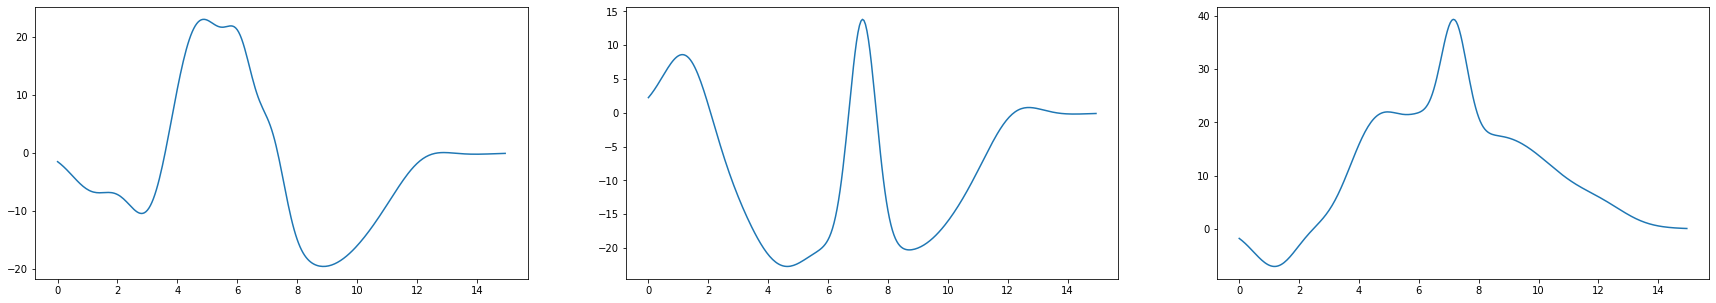

In [20]:
plot_train(input_, 3, target)

0
0 epoch MSE Loss: 362800.49255263264
249 epoch MSE Loss: 257.20409639966
499 epoch MSE Loss: 253.78113872865944
749 epoch MSE Loss: 252.12001286238657
999 epoch MSE Loss: 251.07926508191852
1249 epoch MSE Loss: 250.3392086705067
1499 epoch MSE Loss: 249.7392808017911
1749 epoch MSE Loss: 249.2078735099054
1999 epoch MSE Loss: 248.7142826719998
2249 epoch MSE Loss: 248.24378610978394
2499 epoch MSE Loss: 247.78735150449032
2749 epoch MSE Loss: 247.33756195548253
2999 epoch MSE Loss: 246.88705257383987
train_loss tensor(246.8852, device='cuda:0', dtype=torch.float64)
best loss :  tensor(246.8871, device='cuda:0', dtype=torch.float64)


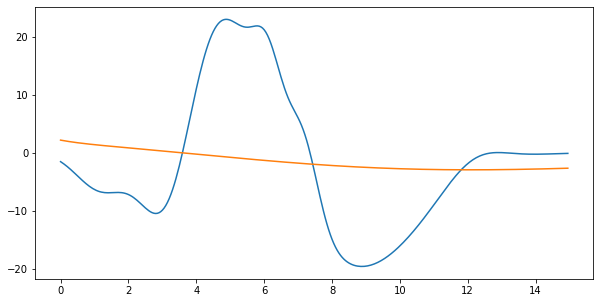

1
tensor(217730.8211, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 247.14443612669353
1999 epoch MSE Loss: 246.34781721442928
2999 epoch MSE Loss: 245.80922148045508
train_loss tensor(245.8087, device='cuda:0', dtype=torch.float64)
best loss :  tensor(245.8092, device='cuda:0', dtype=torch.float64)


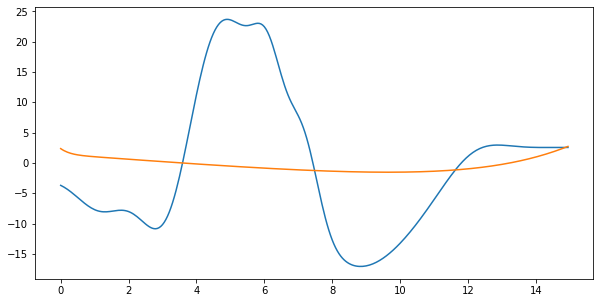

2
tensor(238298.0309, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 93.66045731966578
1999 epoch MSE Loss: 63.27946255125627
2999 epoch MSE Loss: 51.38690446177076
train_loss tensor(51.3786, device='cuda:0', dtype=torch.float64)
best loss :  tensor(51.3869, device='cuda:0', dtype=torch.float64)


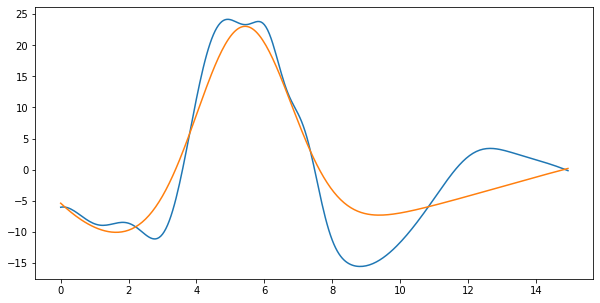

3
tensor(20803.1464, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 30.538887846843398
1999 epoch MSE Loss: 25.373539340694503
2999 epoch MSE Loss: 14.55164881732676
train_loss tensor(14.5442, device='cuda:0', dtype=torch.float64)
best loss :  tensor(14.5516, device='cuda:0', dtype=torch.float64)


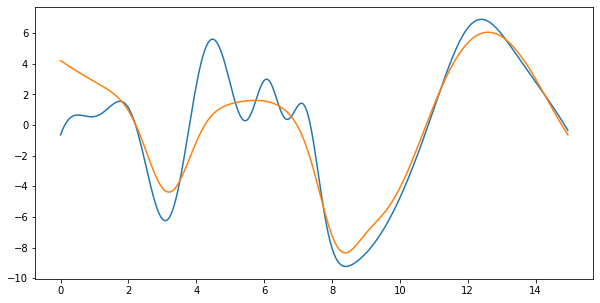

4
tensor(2416.8062, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 11.95429105303721
1999 epoch MSE Loss: 11.906822442754674
2999 epoch MSE Loss: 11.883494844395239
train_loss tensor(11.8835, device='cuda:0', dtype=torch.float64)
best loss :  tensor(11.8835, device='cuda:0', dtype=torch.float64)
change lr  0.0001
----------------------------------------------


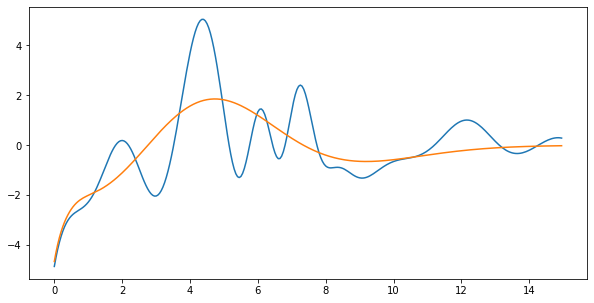

5
tensor(37.5410, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 11.87599851856087
1999 epoch MSE Loss: 9.3470384213615
2999 epoch MSE Loss: 3.2908169741701583
train_loss tensor(2.4697, device='cuda:0', dtype=torch.float64)
best loss :  tensor(2.0070, device='cuda:0', dtype=torch.float64)


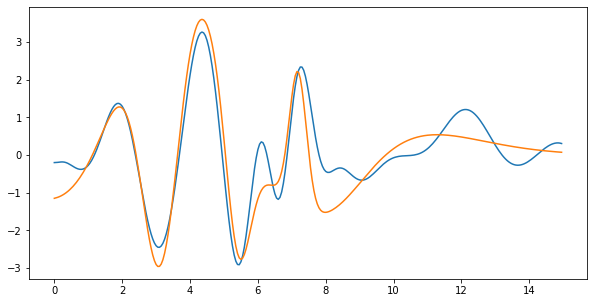

In [23]:
model1 = RBF_Add(30, device)
model1.train(input_,single_target1, 3000, 0.00001, 5, 12)

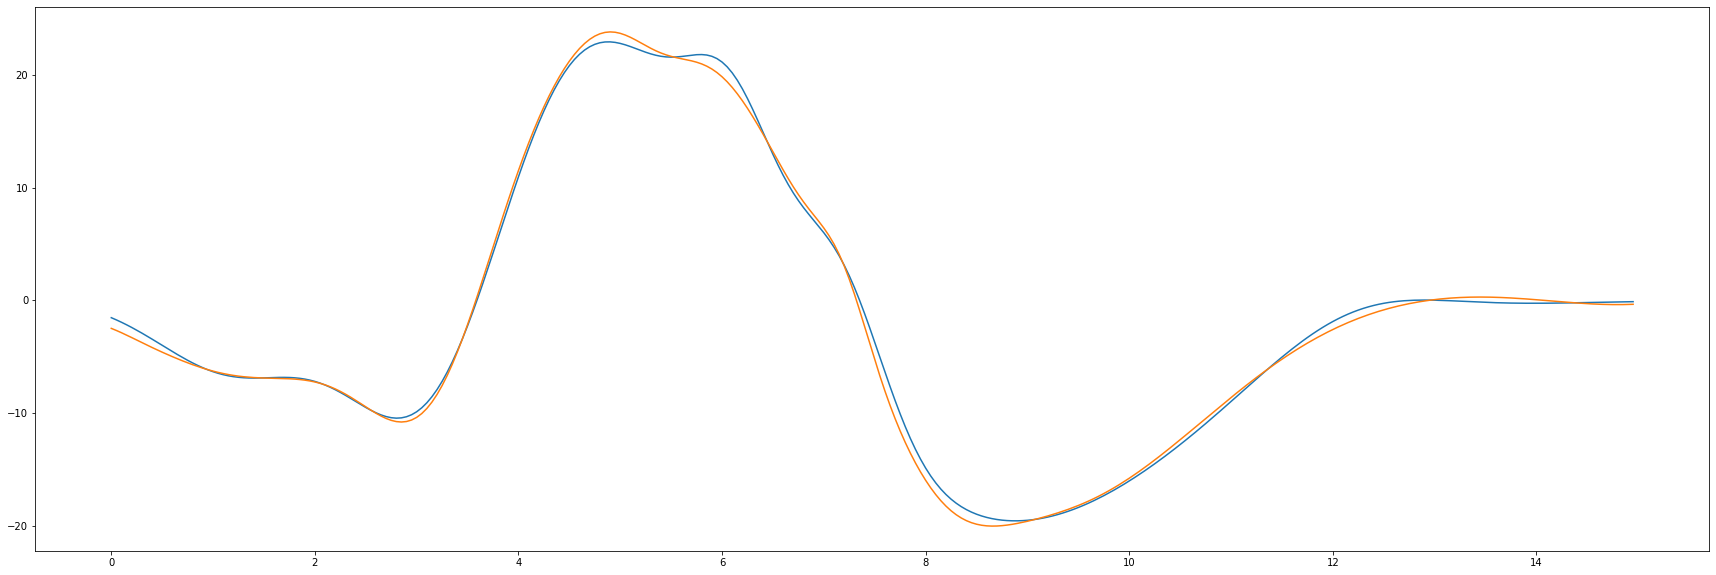

In [24]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target1[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model1.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

0
0 epoch MSE Loss: 427019.4847258905
249 epoch MSE Loss: 297.1160219077519
499 epoch MSE Loss: 297.1150228643201
749 epoch MSE Loss: 297.114023886261
999 epoch MSE Loss: 297.1130249723243
1249 epoch MSE Loss: 297.11202612126095
1499 epoch MSE Loss: 297.1110273318228
1749 epoch MSE Loss: 297.110028602763
1999 epoch MSE Loss: 297.10902993283554
2249 epoch MSE Loss: 297.10803132079565
2499 epoch MSE Loss: 297.1070327653993
2749 epoch MSE Loss: 297.10603426540376
2999 epoch MSE Loss: 297.1050358195674
train_loss tensor(297.1050, device='cuda:0', dtype=torch.float64)
best loss :  tensor(297.1050, device='cuda:0', dtype=torch.float64)


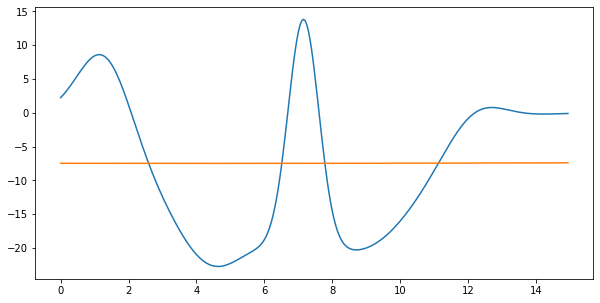

1
tensor(44999.9967, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 265.70067034335443
1999 epoch MSE Loss: 238.7030789836763
2999 epoch MSE Loss: 232.59769402844174
train_loss tensor(232.5922, device='cuda:0', dtype=torch.float64)
best loss :  tensor(232.5977, device='cuda:0', dtype=torch.float64)


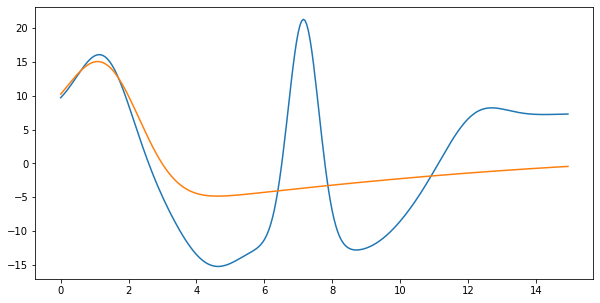

2
tensor(33078.9091, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 13.34482553261793
1999 epoch MSE Loss: 5.583119752113183
2999 epoch MSE Loss: 4.6185931464586645
train_loss tensor(4.6181, device='cuda:0', dtype=torch.float64)
best loss :  tensor(4.6186, device='cuda:0', dtype=torch.float64)
change lr  0.0001
----------------------------------------------


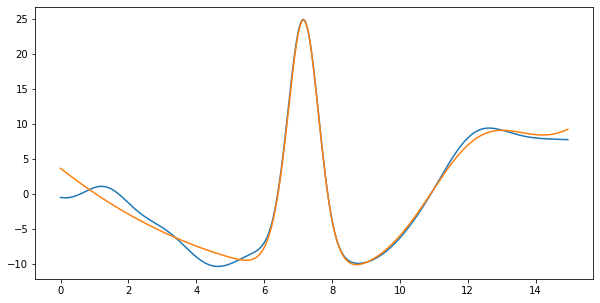

In [25]:
model2 = RBF_Add(30, device)
model2.train(input_,single_target2, 3000, 0.00001, 5, 12)

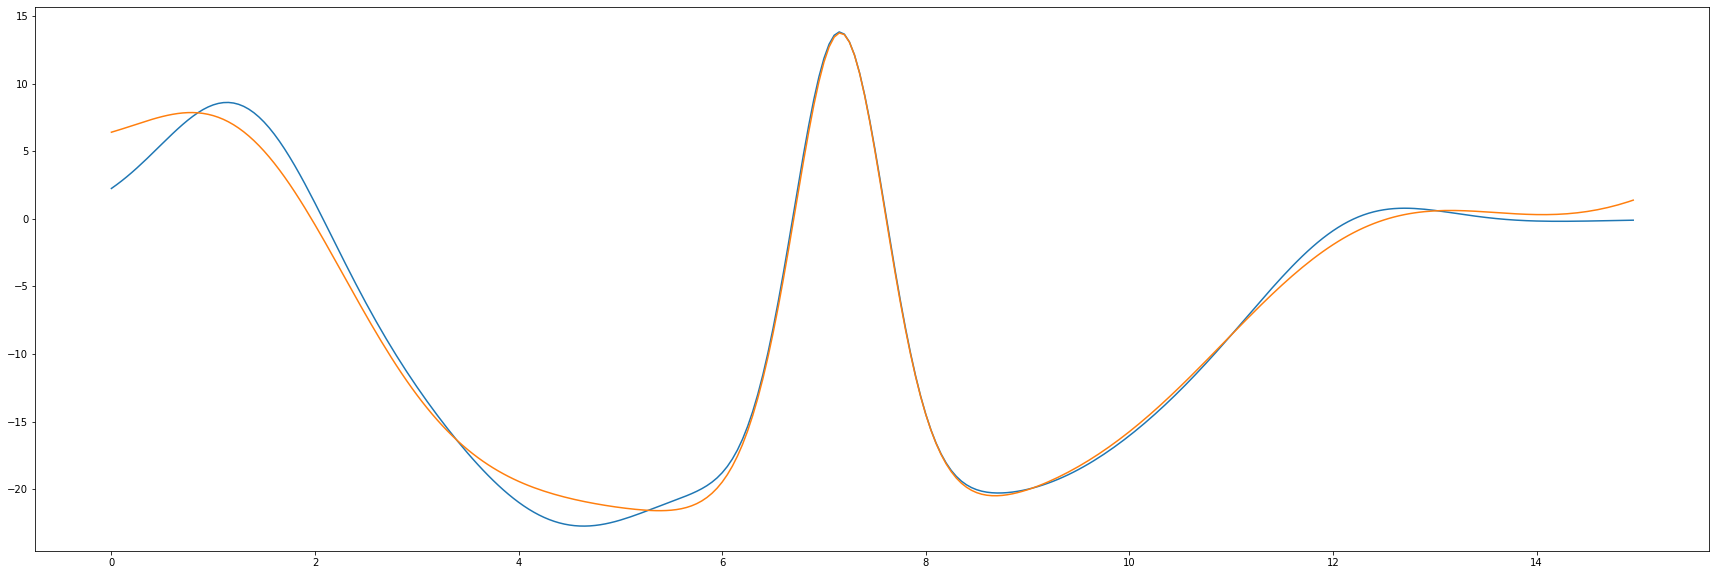

In [26]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target2[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model2.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

0
0 epoch MSE Loss: 620771.5399337024
249 epoch MSE Loss: 211.09875028203385
499 epoch MSE Loss: 211.08544838281225
749 epoch MSE Loss: 211.07224353401526
999 epoch MSE Loss: 211.05913375107875
1249 epoch MSE Loss: 211.0461170930096
1499 epoch MSE Loss: 211.03319166113448
1749 epoch MSE Loss: 211.0203555978901
1999 epoch MSE Loss: 211.00760708565244
2249 epoch MSE Loss: 210.99494434560472
2499 epoch MSE Loss: 210.98236563664162
2749 epoch MSE Loss: 210.96986925430912
2999 epoch MSE Loss: 210.95745352977744
train_loss tensor(210.9575, device='cuda:0', dtype=torch.float64)
best loss :  tensor(210.9575, device='cuda:0', dtype=torch.float64)


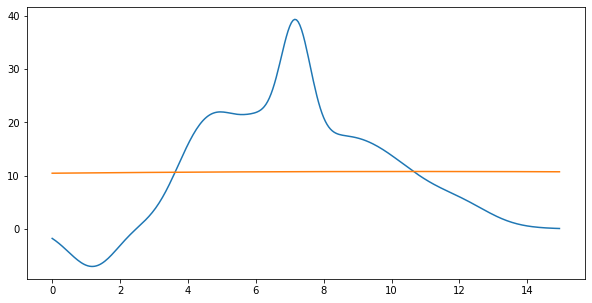

1
tensor([7.1500, 7.2000, 7.1000, 7.2500, 7.0500, 7.3000, 7.0000, 7.3500, 6.9500,
        7.4000, 6.9000, 7.4500, 6.8500, 7.5000, 6.8000, 6.7500, 7.5500, 6.7000,
        7.6000, 6.6500, 7.6500, 6.6000, 1.2000, 1.1500, 1.2500, 1.1000, 1.3000,
        1.0500, 1.3500, 1.0000], device='cuda:0', dtype=torch.float64) tensor([ 28.5491,  28.4537,  28.3710,  28.0855,  27.9301,  27.4559,  27.2472,
         26.5866,  26.3526,  25.5081,  25.2837,  24.2577,  24.0829,  22.8771,
         22.7952,  21.4653,  21.4102,  20.1357,  19.9009,  18.8445,  18.3903,
         17.6235, -17.5422, -17.5362, -17.5114, -17.4939, -17.4437, -17.4164,
        -17.3397, -17.3052], device='cuda:0', dtype=torch.float64) tensor([25.6360, 25.6443, 25.6263, 25.6514, 25.6153, 25.6572, 25.6031, 25.6617,
        25.5895, 25.6649, 25.5745, 25.6668, 25.5583, 25.6674, 25.5406, 25.5217,
        25.6668, 25.5013, 25.6649, 25.4796, 25.6617, 25.4564,  1.6032,  4.0988,
         2.0019,  3.0873,  3.2440, 10.9937,  3.8711,  2.9299], devic

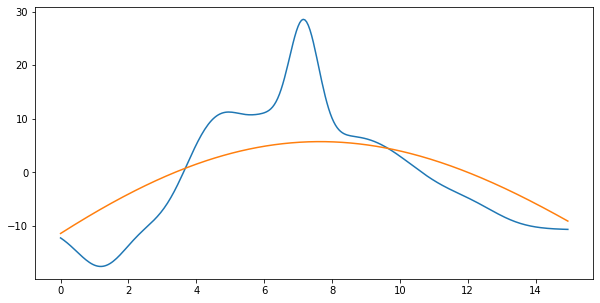

2
tensor([7.1500, 7.2000, 7.1000, 7.2500, 7.0500, 7.3000, 7.0000, 7.3500, 6.9500,
        7.4000, 6.9000, 6.8500, 7.4500, 6.8000, 7.5000, 6.7500, 7.5500, 6.7000,
        7.6000, 6.6500, 7.6500, 6.6000, 7.7000, 6.5500, 1.4500, 1.4000, 1.5000,
        1.3500, 1.5500, 1.3000], device='cuda:0', dtype=torch.float64) tensor([ 22.8863,  22.7758,  22.7249,  22.3941,  22.3023,  21.7526,  21.6393,
         20.8731,  20.7662,  19.7860,  19.7204,  18.5443,  18.5285,  17.2829,
         17.1424,  15.9809,  15.6717,  14.6809,  14.1601,  13.4208,  12.6489,
         12.2325,  11.1752,  11.1409, -11.1160, -11.1129, -11.0861, -11.0751,
        -11.0256, -11.0008], device='cuda:0', dtype=torch.float64) tensor([ 8.2626,  8.2579,  8.2681,  8.2539,  8.2743,  8.2506,  8.2813,  8.2481,
         8.2890,  8.2463,  8.2976,  8.3069,  8.2452,  8.3170,  8.2448,  8.3279,
         8.2452,  8.3396,  8.2463,  8.3522,  8.2481,  8.3656,  8.2506,  8.3799,
        11.0781, 10.1602, 12.1343,  9.3286, 13.3469,  8.6331], devic

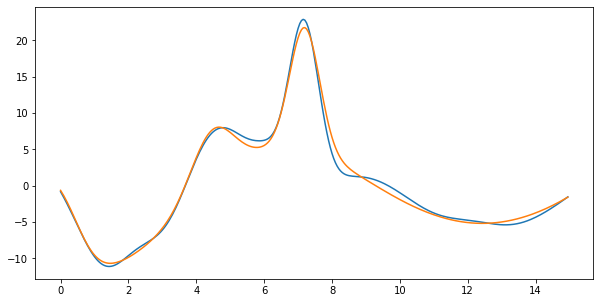

In [66]:
model3 = RBF_Add(30, device)
model3.train(input_,single_target3, 3000, 0.00001, 5, 12)

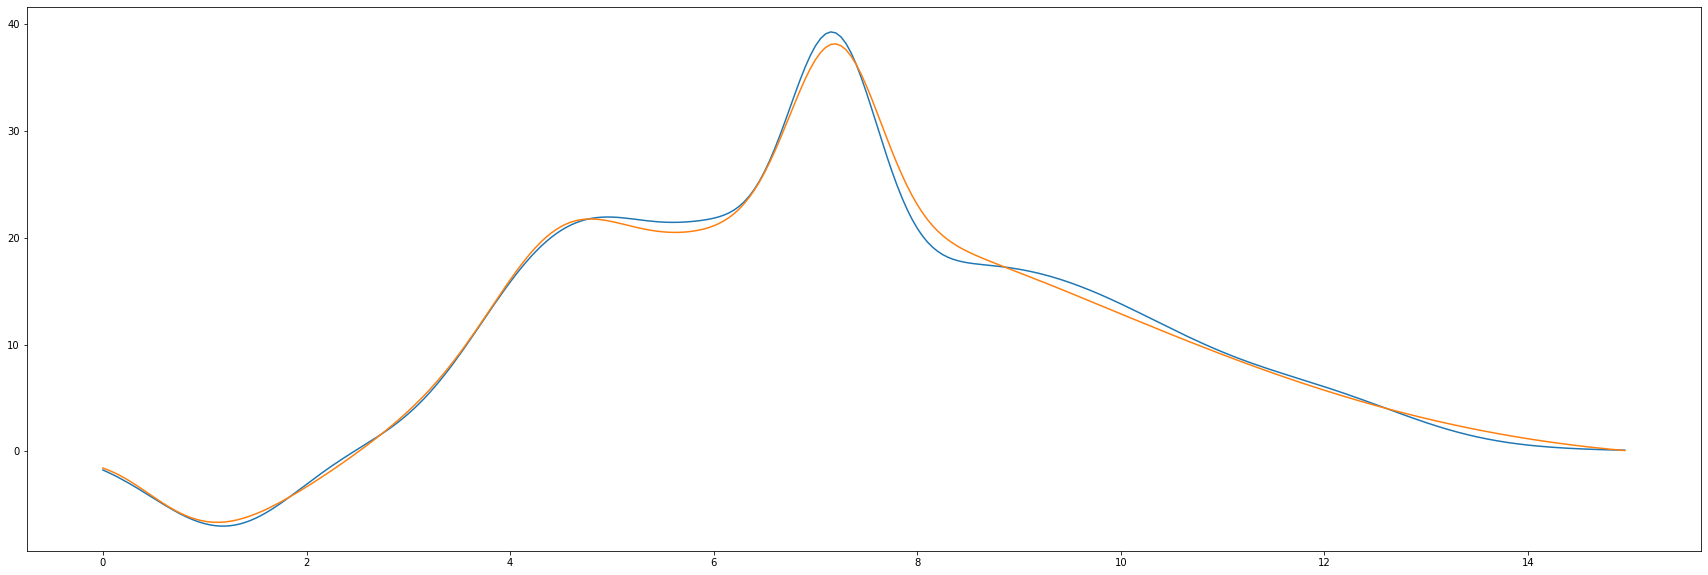

In [28]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target3[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model3.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

# Compare sigma

In [41]:
def rbf_gaussian_derivative_sigma(input_data):
    output = (2 * torch.pow((input_data - radial_layer_centers), 2) / \
                (torch.pow(radial_sigma, 3))) * rbf_gaussian(input_data, radial_layer_centers, radial_sigma)

    return output  # size = (num_radial, 1)

In [30]:
def rbf_gaussian(input_data,r_c, r_s):
    out = torch.exp(-1 *(torch.pow((input_data - r_c), 2)) / (torch.pow(r_s, 2)))

    return out

In [48]:
def L2_F(input_data):
    return -2 * (input_data - radial_layer_centers) / torch.pow(radial_sigma, 2)

In [29]:
linear_layer_weights = torch.tensor([[1.23, 2.34, 10.25, 5.61]], dtype=float, device=device)
radial_layer_centers = torch.tensor([[1.0], [2.0], [3.2], [4.7]], dtype=float, device=device)
radial_sigma = torch.tensor([[0.251], [2.3], [1.2], [1.7]], dtype=float, device=device)

In [34]:
single_target1.size()

torch.Size([1, 300])

In [36]:
pred = torch.matmul(linear_layer_weights, rbf_gaussian(input_, radial_layer_centers, radial_sigma))

In [38]:
pred_grad = pred 

In [39]:
add_rbf_number = 4
L2_1_error = -2 * (single_target1 - pred)
L2_2_error = -2 * (single_target1 - pred_grad)

In [ ]:
# sigma update
deltaSigma1 = rbf_gaussian_derivative_sigma(input_data) * L2_1_error
deltaSigma1 *= linear_layer_weights.reshape(add_rbf_number, 1)

deltaSigma2 = rbf_gaussian_derivative_sigma(input_data) * L2_2_error
deltaSigma2 *= L2_F(input_data) * linear_layer_weights.reshape(add_rbf_number, 1)

deltaSigma =  torch.sum(deltaSigma1, dim=1) + torch.sum(deltaSigma2, dim=1)

In [46]:
deltaSigma1 = rbf_gaussian_derivative_sigma(input_) * L2_1_error
deltaSigma1 *= linear_layer_weights.reshape(add_rbf_number, 1)

In [47]:
torch.sum(deltaSigma1, dim=1)

tensor([ 772.8638,  -98.2507, 2128.8981, 1680.0661], device='cuda:0',
       dtype=torch.float64)

In [50]:
deltaSigma2 = rbf_gaussian_derivative_sigma(input_) * L2_2_error
deltaSigma2 *= L2_F(input_) * linear_layer_weights.reshape(add_rbf_number, 1)

In [52]:
torch.sum(deltaSigma2, dim=1)

tensor([-1318.1537,   700.9640, 16106.6912,  5357.2167], device='cuda:0',
       dtype=torch.float64)

# Compare weights

In [53]:
radial_output = rbf_gaussian(input_, radial_layer_centers, radial_sigma)

In [ ]:
delta_weight1 = torch.sum((radial_output * L2_1_error), dim=1)
delta_weight1 = delta_weight1.reshape(1, add_rbf_number)  
delta_weight2 = torch.sum((L2_2_derivateive_weight(input_data, radial_output) * L2_2_error), dim = 1)
delta_weight2 = delta_weight2.reshape(1, add_rbf_number)
delta_weight = delta_weight1 + delta_weight2

In [54]:
delta_weight1 = torch.sum((radial_output * L2_1_error), dim=1)
delta_weight1 = delta_weight1.reshape(1, add_rbf_number)  

In [55]:
delta_weight1

tensor([[ 168.1313, 1556.1913, 1106.7864, -562.2256]], device='cuda:0',
       dtype=torch.float64)

In [56]:
def L2_2_derivateive_weight(input_data, radial_output):
    return (-2 *(input_data - radial_layer_centers) / torch.pow(radial_sigma,2)) * radial_output

In [58]:
delta_weight2 = torch.sum((L2_2_derivateive_weight(input_, radial_output) * L2_2_error), dim = 1)
delta_weight2 = delta_weight2.reshape(1, add_rbf_number)

In [59]:
delta_weight2

tensor([[ -89.4611,    5.9893,  759.1135, 1002.1133]], device='cuda:0',
       dtype=torch.float64)

# Compare Centers

In [60]:
def rbf_gaussian_derivative_centers(input_data):
    output = (2 * (input_data - radial_layer_centers) / \
                (torch.pow(radial_sigma, 2))) * rbf_gaussian(input_data, radial_layer_centers, radial_sigma)

    return output  # size = (num_radial, 1)

In [61]:
deltaCenter1 = rbf_gaussian_derivative_centers(input_) * L2_1_error
deltaCenter1 *= linear_layer_weights.reshape(add_rbf_number, 1)

deltaCenter2 = rbf_gaussian_derivative_centers(input_) * L2_2_error
deltaCenter2 *= L2_F(input_) * linear_layer_weights.reshape(add_rbf_number, 1)
deltaCenter =  torch.sum(deltaCenter1, dim=1) + torch.sum(deltaCenter2, dim=1)

In [62]:
deltaCenter

tensor([ -6048.2405,     71.4205, -11329.0769,  -7598.4042], device='cuda:0',
       dtype=torch.float64)